###  CONTENT BASED IMAGE RETRIEVAL

In [6]:
import cv2 as cv
import numpy as np
import scipy
import pickle
import random
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.decomposition import LatentDirichletAllocation
from scipy.spatial.distance import euclidean,cosine
import matplotlib.image as mpimg
import joblib
sift = cv.xfeatures2d.SIFT_create()



In [ ]:
directory='/Users/maddisiddart/Desktop/mydataset'
img_dirs=['stop_sign','sunflower','airplanes','brain','hawksbill','watch']

In [ ]:
img_dirs

### Finding the key points and feature descriptors using SIFT

In [ ]:
desc=[]
X=[]
final_images=[]
for img_dir in img_dirs:
    images = os.listdir(directory+'/'+img_dir)
    for img_name in images:
        img_path=os.path.join(directory,img_dir,img_name)
        img=cv.imread(img_path)
        kps=sift.detect(img)
        kp1, des1 = sift.compute(img, kps)
        try:
            if (des1.all!=None):
                final_images.append(img_path)
                desc.append([])
                desc[-1].append(des1)
                for d in des1:
                    X.append(d)
        except:
            pass

In [ ]:
output = open('descriptor.pkl', 'wb')
pickle.dump(desc,output,pickle.HIGHEST_PROTOCOL) 


In [ ]:
out = open('images.pkl', 'wb')
pickle.dump(final_images,out,pickle.HIGHEST_PROTOCOL)

In [ ]:
len(final_images)

### Clustering of key points to make dictionary using k means

In [ ]:
dictionary_size=2000
kmeans = MiniBatchKMeans(init='k-means++',n_clusters=dictionary_size,batch_size=500,random_state=0).fit(X)
centers=kmeans.cluster_centers_
print("clustered")

In [ ]:
cen = open('clustered_2000.pkl', 'wb')
pickle.dump(centers,cen,pickle.HIGHEST_PROTOCOL)

In [ ]:
centers

### Flann matcher to match key points to words in dictionary

In [ ]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50) 

flann = cv.FlannBasedMatcher(index_params,search_params)
arr=[]
for i in range(len(desc)):
    matches = flann.knnMatch(np.asarray(desc[i][0],np.float32),np.asarray(centers,np.float32),k=1)
    
    arr.append([matches[j][0].trainIdx for j in range(len(matches))])


In [ ]:
'''#creating a histogram
doc=[]
for i in range(len(arr)): 
    hist=[0]*(dictionary_size)
    for j in range(0,dictionary_size):
        l = len((np.where(np.array(arr[i]) == j))[0])
        hist[j] = l
    doc.append(hist)
print("histogram with frequency of words in an image done (method 1)")'''

### Creating a histogram of visual words

In [ ]:
doc_word=[]
for i in range(len(arr)):
    hist=[0]*dictionary_size
    c={}
    for j in range(len(arr[i])):
        if (arr[i][j] in c):
            c[arr[i][j]]+=1
        else:
            c[arr[i][j]]=1
    for k in c:
        hist[k]=c[k]
    doc_word.append(hist)
print("histogram with frequency of words in an image done (method 2)")       
    

In [ ]:
len(doc_word[0])

In [ ]:
his = open('histogram.pkl', 'wb')
pickle.dump(doc_word,his,pickle.HIGHEST_PROTOCOL)

In [ ]:
print(len(doc_word))

### Topic Modelling using Latent Dirichlet Allocation Method 

In [ ]:
ld = LatentDirichletAllocation(n_components=20,learning_method='online',max_iter=100)
ld.fit(doc_word)
topic_dist=ld.transform(doc_word)


In [ ]:
joblib.dump(ld, 'lda_model.jl')


In [ ]:
t_dist = open('topic_dist.pkl', 'wb')
pickle.dump(topic_dist,t_dist,pickle.HIGHEST_PROTOCOL)

In [ ]:
topic_dist


### Loading of models 

In [2]:
o = open('images.pkl', 'rb')
final_images = pickle.load(o)
cen = open('clustered_2000.pkl', 'rb')
centers = pickle.load(cen)
t_distribution = open('topic_dist.pkl', 'rb')
topic_dist = pickle.load(t_distribution)

lda = joblib.load('lda_model.jl')



### Querying images 

In [3]:
#['stop_sign','sunflower','airplanes','brain','hawksbill','watch']
query_image_path='/Users/maddisiddart/Desktop/train/brain/image_0001.jpg'
query_img=cv.imread(query_image_path)
if (type(query_img)!=type(None)):

    query_img_kps=sift.detect(query_img)
    query_kp, query_des = sift.compute(query_img,query_img_kps)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50) 

    flann = cv.FlannBasedMatcher(index_params,search_params)
    query_arr=[]
    matches = flann.knnMatch(np.asarray(query_des,np.float32),np.asarray(centers,np.float32),k=1)
    query_arr.append([matches[j][0].trainIdx for j in range(len(matches))])

    dictionary_size=2000
    q={}
    query_hist=[0]*dictionary_size
    for j in range(len(query_arr[0])):
        if (query_arr[0][j] in q):
            q[query_arr[0][j]]+=1
        else:
            q[query_arr[0][j]]=1
    for k in q:
        query_hist[k]=q[k]

    query_hist=np.array(query_hist).reshape(1,-1)

    query_topic = lda.transform(query_hist)

    euc=[]
    for i in range(len(topic_dist)):
        euc.append([final_images[i],cosine(query_topic[0],topic_dist[i])])

    img_sorted = sorted(euc, key=lambda x: x[1])


In [4]:
img_sorted

[['/Users/maddisiddart/Desktop/mydataset/brain/image_0001.jpg', 0.0],
 ['/Users/maddisiddart/Desktop/mydataset/brain/image_0048.jpg',
  0.003440566661852884],
 ['/Users/maddisiddart/Desktop/mydataset/brain/image_0007.jpg',
  0.004940430637872639],
 ['/Users/maddisiddart/Desktop/mydataset/brain/image_0087.jpg',
  0.008380361515580304],
 ['/Users/maddisiddart/Desktop/mydataset/brain/image_0070.jpg',
  0.01291240835562446],
 ['/Users/maddisiddart/Desktop/mydataset/brain/image_0034.jpg',
  0.01984415682281515],
 ['/Users/maddisiddart/Desktop/mydataset/brain/image_0073.jpg',
  0.02158799484072782],
 ['/Users/maddisiddart/Desktop/mydataset/brain/image_0035.jpg',
  0.021756485209883825],
 ['/Users/maddisiddart/Desktop/mydataset/brain/image_0080.jpg',
  0.022385993958360606],
 ['/Users/maddisiddart/Desktop/mydataset/brain/image_0081.jpg',
  0.03159260748763204],
 ['/Users/maddisiddart/Desktop/mydataset/brain/image_0042.jpg',
  0.03167788117515402],
 ['/Users/maddisiddart/Desktop/mydataset/brai

### Displaying the Queried images 

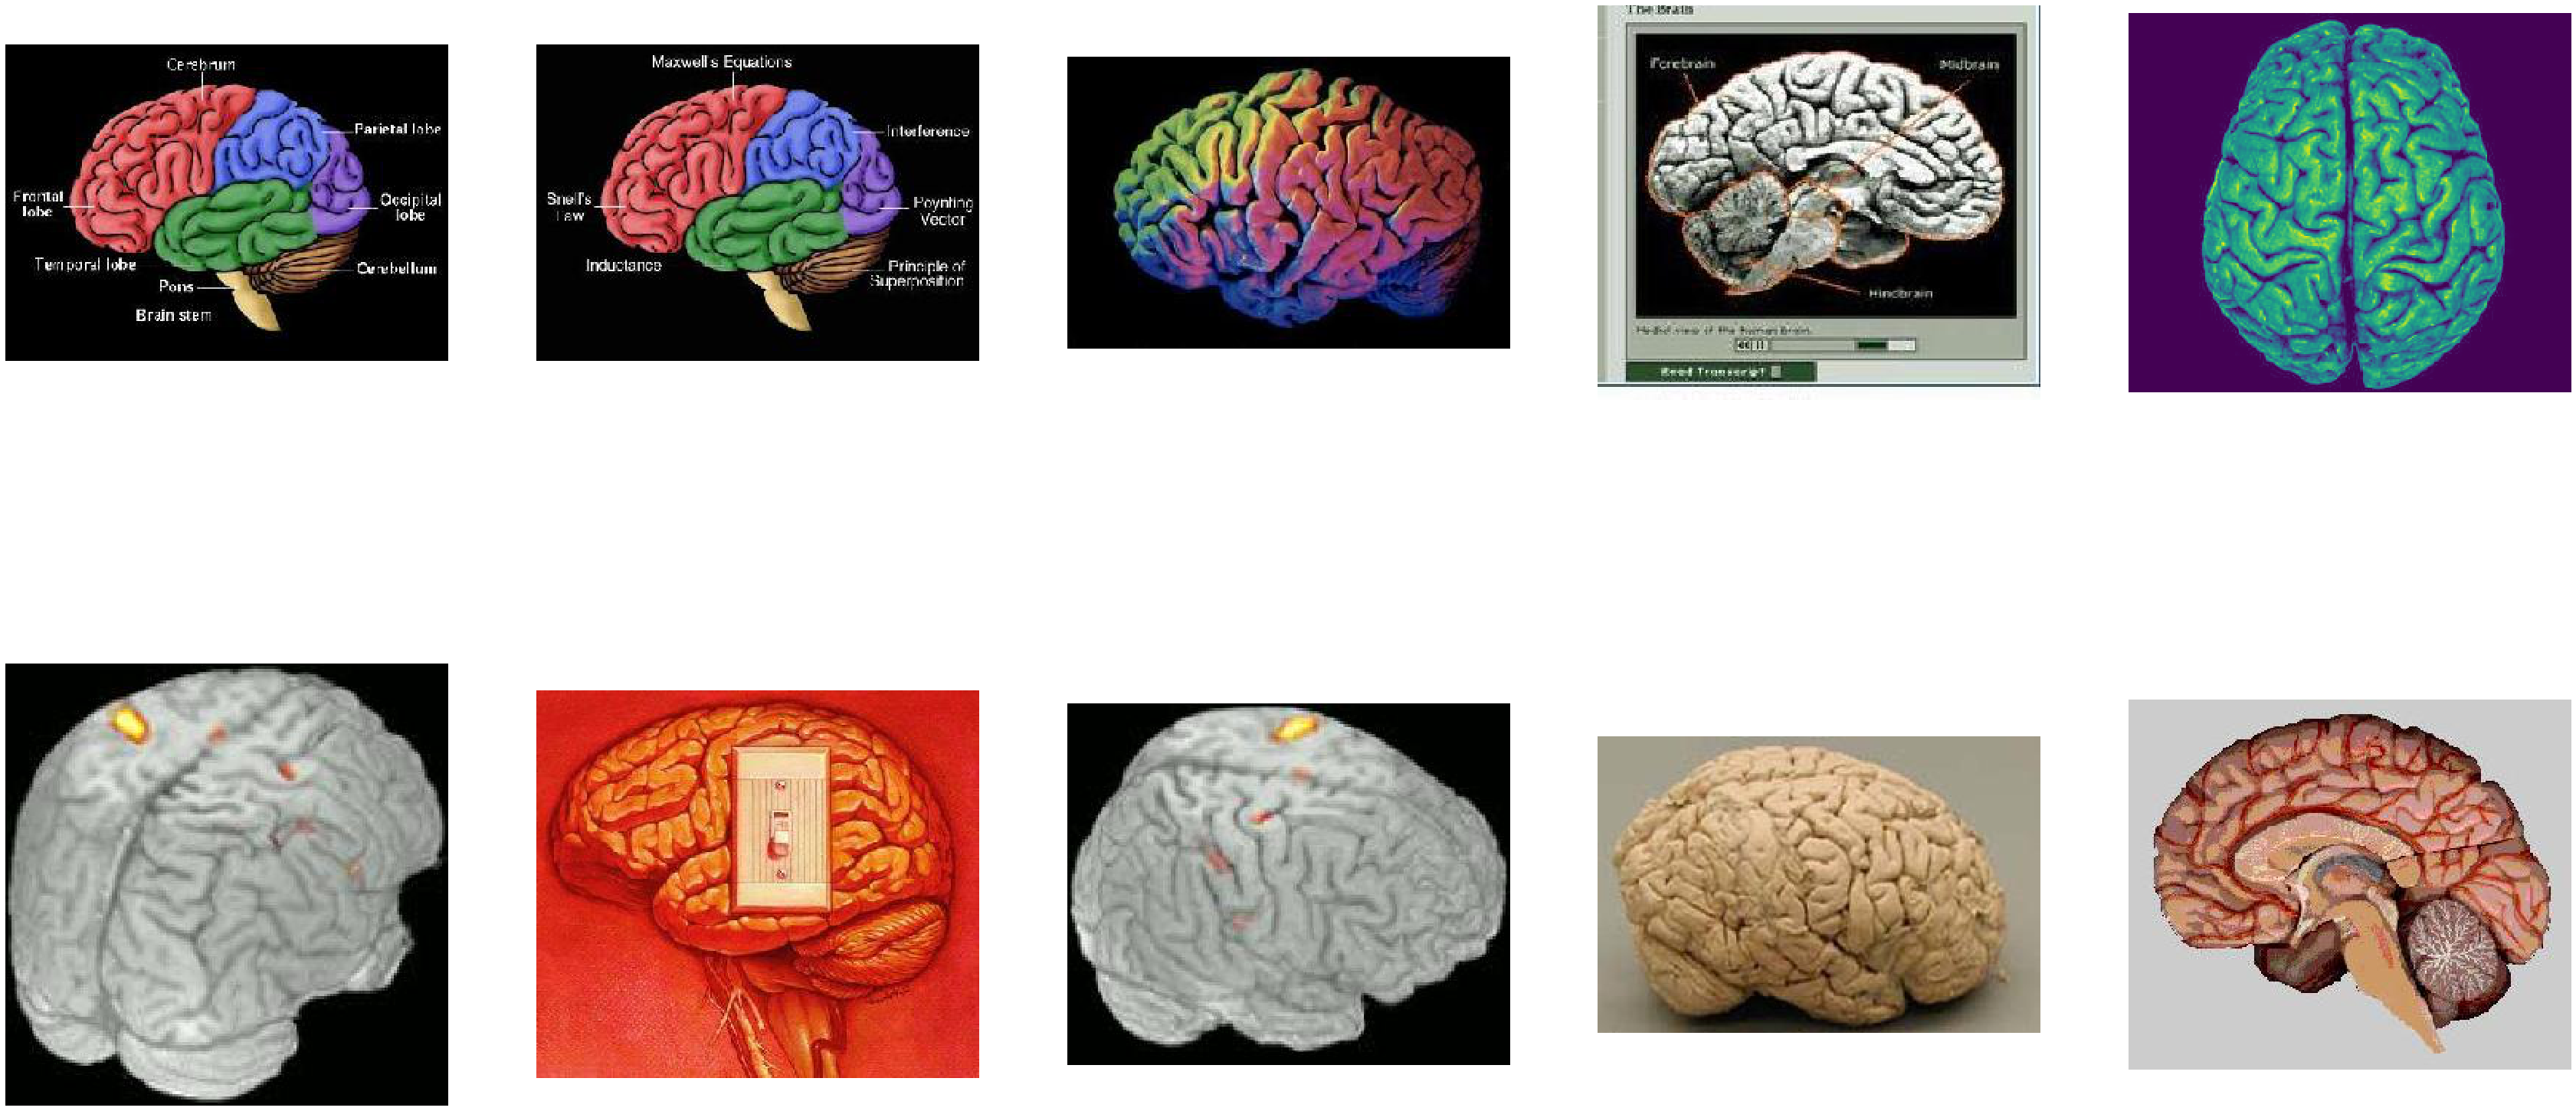

In [5]:
rows = 2    
columns = 5
f, axarr = plt.subplots(rows,columns,figsize=(60,30))
i = 0
j = 0

images = []
for img_path,temp in img_sorted[:10]:
    images.append(mpimg.imread(img_path))

for image in images:
    axarr[i,j].imshow(image)
    axarr[i,j].axis('off')
    j+=1
    if(j%columns == 0):
        i+=1
        j = 0